<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# yahoo finance
import yfinance as yf
# personal scripts
import wrangle as w
# prophet model
from prophet import Prophet
# dataframes & matrices
import pandas as pd
import numpy as np
# stats and eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
# viz
import seaborn as sns
import matplotlib.pyplot as plt
# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
# warnings
import warnings
warnings.filterwarnings("ignore")
# ignore cmdstanpy
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
# for timing hyperparameter runing loop
from timeit import default_timer as timer
import time



In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Acquiring Eth-USD df

In [ ]:
eth_usd = yf.Ticker("eth-usd")

In [ ]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1656.7212
7,open,1656.7212
8,dayLow,1629.4266
9,dayHigh,1656.7212


In [ ]:
eth = eth_usd.history(period='3mo',interval='1h')

In [ ]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


# Preparing Eth

In [ ]:
eth = w.prepare_eth(eth)

# Exploring Eth

<Axes: xlabel='Datetime'>

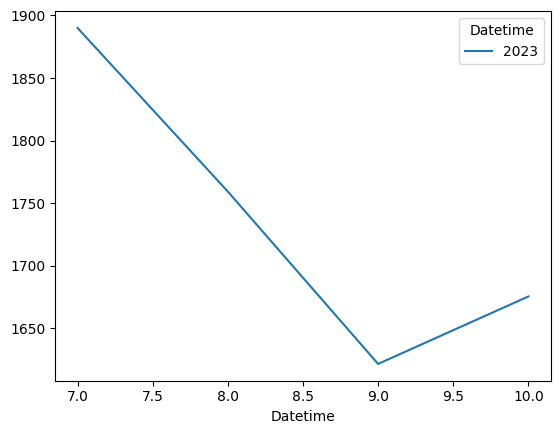

In [ ]:
eth.groupby([eth.index.month,eth.index.year])['close'].mean().unstack().plot()

<Axes: xlabel='month'>

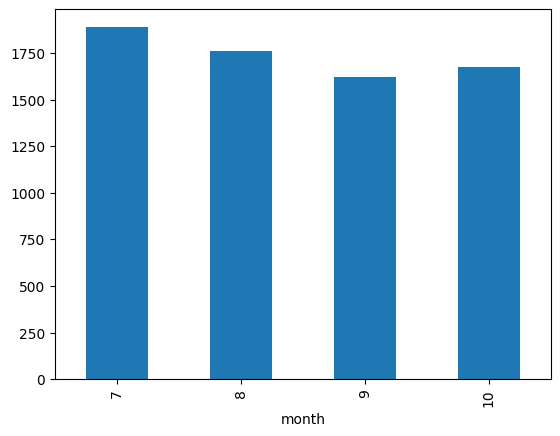

In [ ]:
eth.groupby('month')['close'].mean().plot(kind='bar')

In [ ]:
#sns.histplot(eth.resample('4H'))

In [ ]:
eth.tail()

,open,high,low,close,volume,month,year,weekday,high_low_diff
Datetime,,,,,,,,,
2023-10-04 11:00:00+00:00,1646.521362,1647.559570,1645.388550,1646.192505,627200,10,2023,Wednesday,2.171021
2023-10-04 12:00:00+00:00,1646.260010,1649.923340,1645.133057,1646.653809,15382528,10,2023,Wednesday,4.790283
2023-10-04 13:00:00+00:00,1646.455322,1646.455322,1635.591064,1636.273560,98037760,10,2023,Wednesday,10.864258
2023-10-04 14:00:00+00:00,1635.061523,1637.351440,1629.426636,1633.663818,36983808,10,2023,Wednesday,7.924805
2023-10-04 15:00:00+00:00,1633.788818,1636.493042,1632.609619,1636.022095,10765824,10,2023,Wednesday,3.883423


<Axes: xlabel='Datetime'>

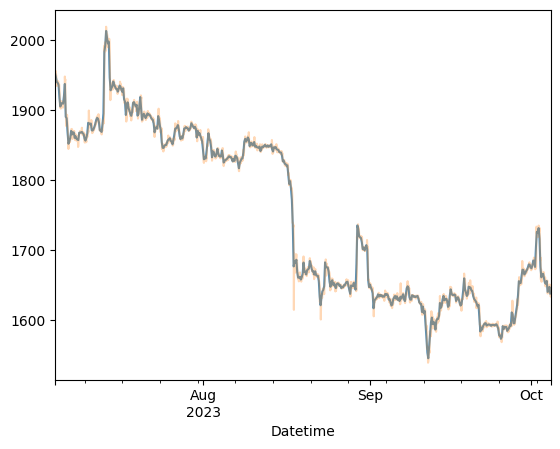

In [ ]:
eth.close.resample('4h').mean().plot(alpha=.8)
eth.close.resample('1h').mean().plot(alpha=.3)

# Split

In [ ]:
train_size = int(eth.shape[0] * .9)
test_size = int(eth.shape[0] * .1)

test_end_index = train_size + test_size


In [ ]:
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

In [ ]:
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (1988,), Test shape: (220,) , Eth shape: (2209, 9)


In [ ]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [ ]:
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')
train_model_fit = train_model.copy()

## Split using SKLearn (Did not use)

In [ ]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Finding Baselines
  - Last Observed Value
  - Simple Average
  - Moving Average

In [ ]:
def metrics_dataframe(model,RMSE):
    '''
    Keep track and automatically append data to compare models.
    '''
    metrics_df = pd.DataFrame(data=[
            {
                'model':model,
                'rmse':RMSE
            }
            ])
    return metrics_df

def save_metrics(df, model, RMSE):
    df.loc[len(df)] = [model, RMSE]
    df = df[~df.duplicated('model')]
    return df

## Last Observed

In [ ]:
# last item in close
last_close = train[-1:][0]

yhat_df = pd.DataFrame(
    {'close': [last_close]},
    index=test_model.index)



In [ ]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.close))

In [ ]:
metrics_df = metrics_dataframe(model = 'last-observed' ,RMSE=score)

In [ ]:
metrics_df

,model,rmse
0,last-observed,83.631198


## Simple Average

In [ ]:
# last item in close
close_avg = train.mean()

yhat_df = pd.DataFrame(
    {'avg': [close_avg]},
    index=test_model.index)


In [ ]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.avg))

In [ ]:
save_metrics(df=metrics_df,model='simple-avg', RMSE=score)

,model,rmse
0,last-observed,83.631198
1,simple-avg,122.361207


## Moving Average

In [ ]:
period = 4

# last item in close
rolling = round(train.rolling(period).mean()[-1], 2)

yhat_df = pd.DataFrame(
    {'rolling': [rolling]},
    index=test_model.index)

In [ ]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df['rolling']))

In [ ]:
save_metrics(df=metrics_df, model = 'moving-avg-4hr',RMSE=score)

,model,rmse
0,last-observed,83.631198
1,simple-avg,122.361207
2,moving-avg-4hr,81.635672


# Initial Prophet model has been fit on about 19 months of prior data and can now be used to make predictions -- this will be used to predict on about 2 months of most recent data (test)

In [ ]:
m = Prophet(yearly_seasonality=False, changepoint_prior_scale=.1)

In [ ]:
train_model_fit

,ds,y
0,2023-07-04 15:00:00,1953.701294
1,2023-07-04 16:00:00,1956.197266
2,2023-07-04 17:00:00,1950.657349
3,2023-07-04 18:00:00,1949.895264
4,2023-07-04 19:00:00,1935.219116
...,...,...
1983,2023-09-25 06:00:00,1578.745850
1984,2023-09-25 07:00:00,1580.727417
1985,2023-09-25 08:00:00,1577.583130
1986,2023-09-25 09:00:00,1573.308960


In [ ]:
model = m.fit(train_model_fit)

## Forecast DF with predicted values

In [ ]:
future = model.make_future_dataframe(periods=40, freq='H')
forecast = model.predict(future)

# Test predicted

In [ ]:
testmodel_forecast = model.predict(test_model)

## Exploring Forecast for train and test

In [ ]:
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-07-04 15:00:00,1945.781447,-3.857247,0.137635,1942.061835
1,2023-07-04 16:00:00,1944.470187,-3.227635,0.196641,1941.439193
2,2023-07-04 17:00:00,1943.158927,-2.592168,0.238373,1940.805132
3,2023-07-04 18:00:00,1941.847666,-1.954349,0.008125,1939.901442
4,2023-07-04 19:00:00,1940.536406,-1.317606,-0.528939,1938.689862
...,...,...,...,...,...
2023,2023-09-26 22:00:00,1601.828310,0.553598,-0.981899,1601.400009
2024,2023-09-26 23:00:00,1601.772829,1.154216,-0.366089,1602.560955
2025,2023-09-27 00:00:00,1601.717347,1.738672,0.121705,1603.577724
2026,2023-09-27 01:00:00,1601.661866,2.304516,0.199553,1604.165935


In [ ]:
testmodel_forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-09-25 11:00:00,1603.770153,-8.410122,0.687338,1596.047369
1,2023-09-25 12:00:00,1603.714672,-8.787354,0.707222,1595.634540
2,2023-09-25 13:00:00,1603.659191,-9.135619,0.517458,1595.041031
3,2023-09-25 14:00:00,1603.603710,-9.451768,0.258676,1594.410617
4,2023-09-25 15:00:00,1603.548228,-9.732882,0.137635,1593.952981
...,...,...,...,...,...
215,2023-10-04 10:00:00,1591.841686,6.275079,0.521753,1598.638518
216,2023-10-04 11:00:00,1591.786205,6.573838,0.687338,1599.047380
217,2023-10-04 12:00:00,1591.730723,6.843256,0.707222,1599.281202
218,2023-10-04 13:00:00,1591.675242,7.083767,0.517458,1599.276468


<Axes: xlabel='Datetime', ylabel='y'>

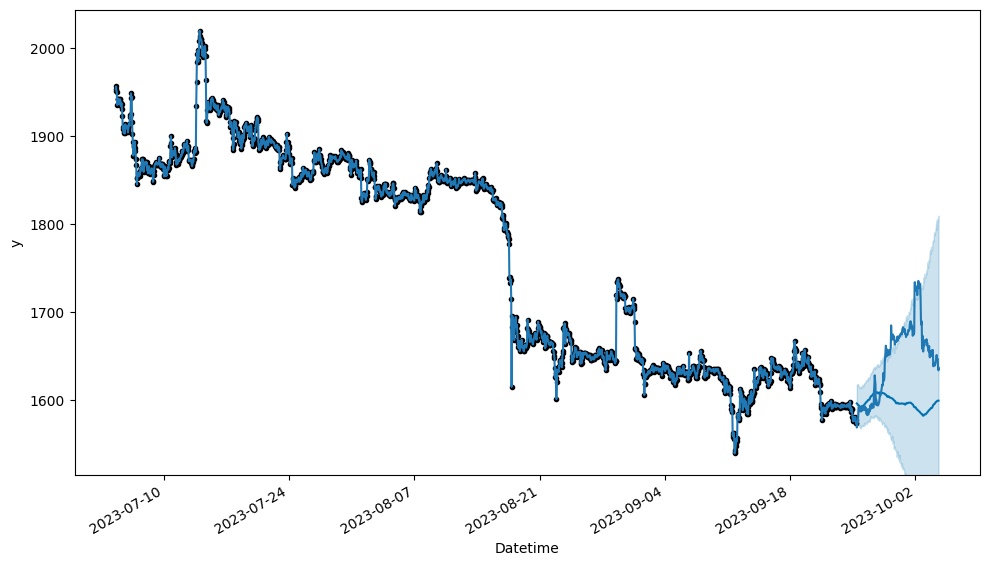

In [ ]:
model.plot(testmodel_forecast)
eth.close.plot()

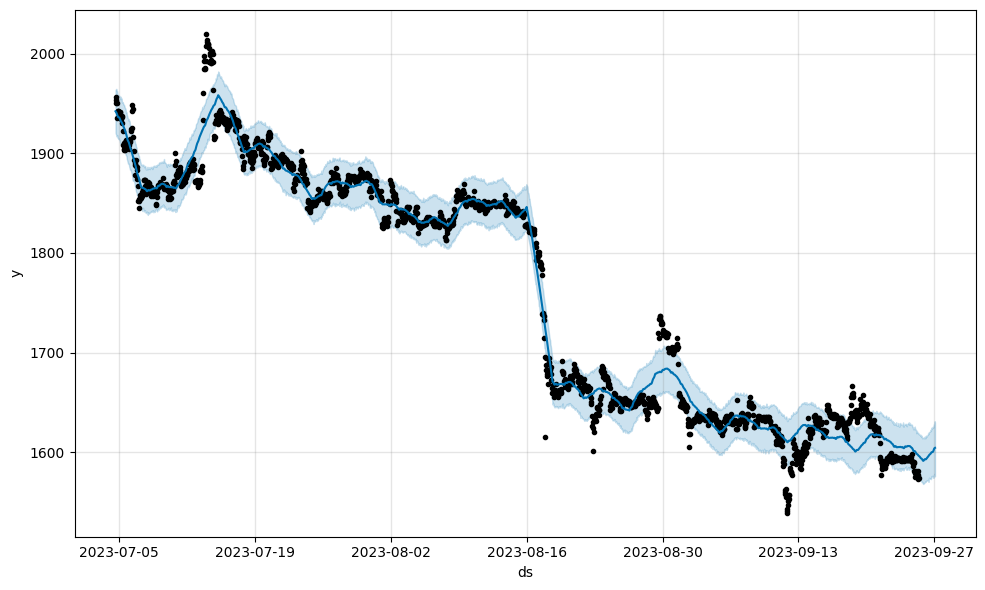

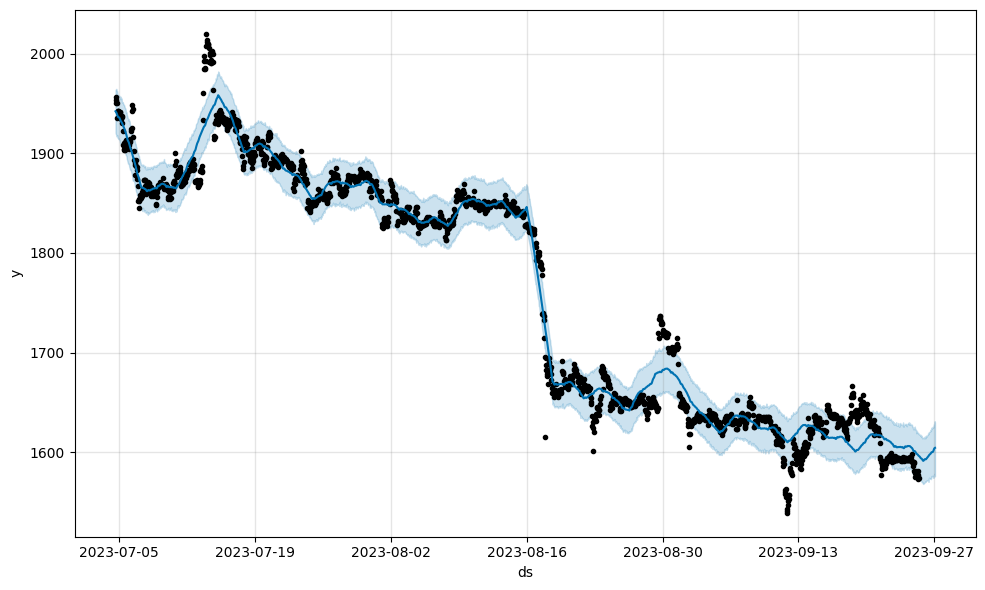

In [ ]:
m.plot(forecast)

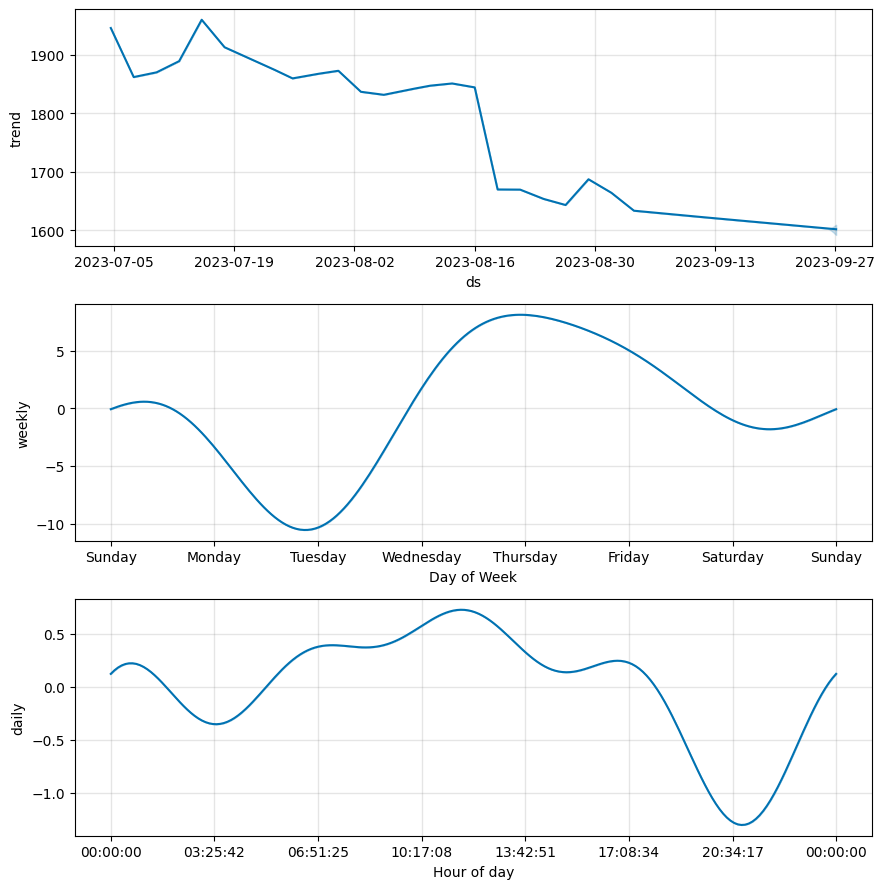

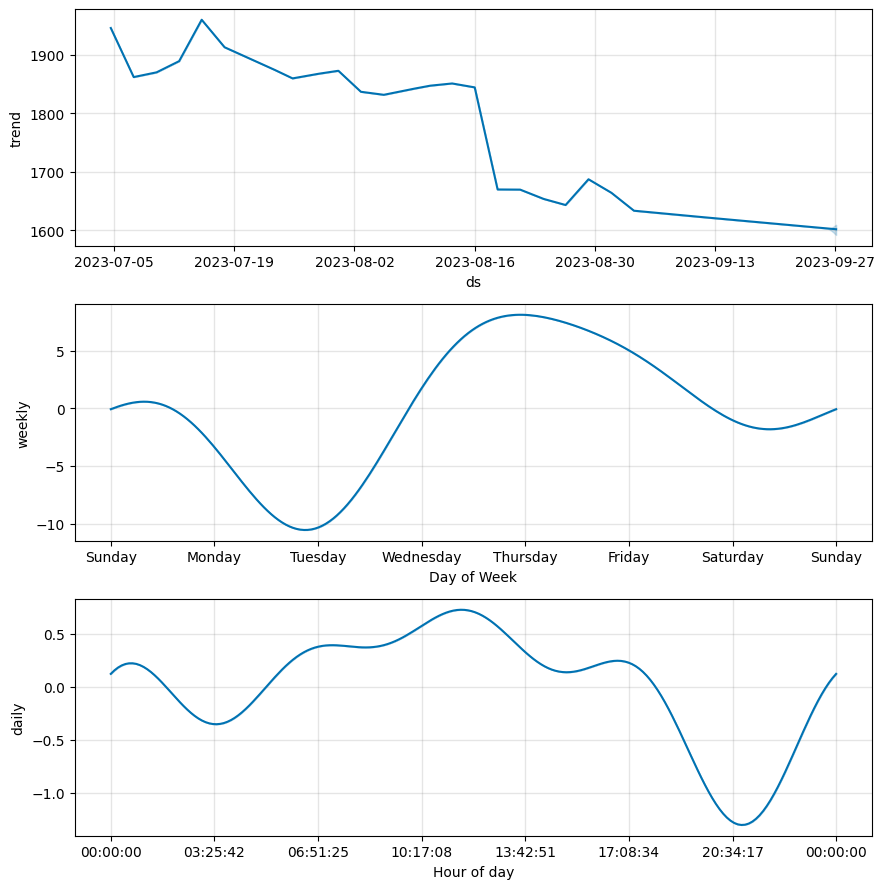

In [ ]:
m.plot_components(forecast)

# Parameter Tuning

In [ ]:
# importing US holidays for model date identification

import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2023]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'holidays_prior_scale':[3,4,5,6,7],
          'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0
for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 250


In [ ]:
start = timer()
12340 ** 348234
end = timer()
mytime = end - start
type(mytime)

float

In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','RMSE','Parameters'])
i = 0
total_time = 0
for x in grid:
    start = timer()
    test = pd.DataFrame()
    i += 1
    print(f'Num of Iteration: {i} of {its}')
    print(x)
    np.random.seed(4343)
    train_model_loop =Prophet(
                         changepoint_prior_scale = x['changepoint_prior_scale'],
                         holidays_prior_scale = x['holidays_prior_scale'],
                         seasonality_mode = x['seasonality_mode'],
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         #holidays=holiday,
                         interval_width=0.95)
    # train_model_loop.add_country_holidays(country_name='US')

    # Removed holidays due to the low factor of importance for cryptocurrency trading, this resulted in
    # marginal increases to accuracy

    train_model_loop.fit(train_model)
    train_forecast = train_model_loop.make_future_dataframe(periods=4, freq='H',include_history = False)
    train_forecast = train_model_loop.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(test_model.y.tail(4),abs(test[['yhat']]))
    RMSE = sqrt(mean_squared_error(test_model.y.tail(4),abs(test[['yhat']])))
    print('Mean Absolute Percentage Error(MAPE): +++++++',round(MAPE * 100, 4) )
    print('Root Mean Squared Error(RMSE): +++++++',round(RMSE, 4) )
    end = timer()
    runtime = round(end - start, 2)
    total_time += runtime
    print(f'Time (SECONDS): {runtime}, Total time (SECONDS): {total_time}, Total time (MINUTES): {total_time / 60} ')
    model_parameters = model_parameters.append({'MAPE':round(MAPE * 100, 2),'RMSE':round(RMSE * 100, 2),'Parameters':x},ignore_index=True)


Num of Iteration: 1 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.706
Root Mean Squared Error(RMSE): +++++++ 44.7294
Time (SECONDS): 3.07, Total time (SECONDS): 3.07, Total time (MINUTES): 0.051166666666666666 
Num of Iteration: 2 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.7668
Root Mean Squared Error(RMSE): +++++++ 45.7122
Time (SECONDS): 1.82, Total time (SECONDS): 4.89, Total time (MINUTES): 0.08149999999999999 
Num of Iteration: 3 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.706
Root Mean Squared Error(RMSE): +++++++ 44.7294
Time (SECONDS): 1.42, Total time (SECONDS): 6.31, Total time (MIN

In [ ]:
metrics_df

,model,rmse
0,last-observed,83.631198
1,simple-avg,122.361207
2,moving-avg-4hr,81.635672


In [ ]:
saved_params = model_parameters.copy()

In [ ]:
pd.set_option('display.max_colwidth', None)
saved_params

,MAPE,RMSE,Parameters
0,2.71,NaN,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
1,2.77,NaN,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive'}"
2,2.71,NaN,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative'}"
3,2.77,NaN,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 4, 'seasonality_mode': 'additive'}"
4,2.71,NaN,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative'}"
...,...,...,...
245,2.77,NaN,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive'}"
246,2.73,NaN,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'holidays_prior_scale': 6, 'seasonality_mode': 'multiplicative'}"
247,2.77,NaN,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'holidays_prior_scale': 6, 'seasonality_mode': 'additive'}"
248,2.73,NaN,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"


In [ ]:
saved_params.sort_values('MAPE',ascending=True,inplace=True)

In [ ]:
saved_params.Parameters.iloc[208]

In [ ]:
# exporting hyperparams as csv to save data

# saved_params.to_csv('hyperparams.csv')